In [1]:
import numpy as np
from time import time
from tqdm import tqdm

import os
if 'HOSTNAME' not in os.environ:
    os.environ['HOSTNAME'] = 'ODIN' # or 'ODIN'ArithmeticError
os.makedirs('output', exist_ok=True) # check that output dir is there

from core.insilico_exps import ExperimentEvolution
from core.GAN_utils import upconvGAN
from core.CNN_scorers import TorchScorer
from core.Optimizers import Genetic, CholeskyCMAES

In [2]:
population_size = 40
mutation_rate = 0.25
mutation_size = 0.75
kT_multiplier = 2
n_conserve = 10
parental_skew = 0.75
optimizer = Genetic(4096, population_size, mutation_rate, mutation_size, kT_multiplier,
                    parental_skew=parental_skew, n_conserve=n_conserve)

In [3]:
# from core.GAN_utils import load_statedict_from_online
# a = load_statedict_from_online()

In [4]:
# G = upconvGAN("fc6")
# G.eval().cuda()
# G.requires_grad_(False)

In [19]:
tmpsavedir = 'output' # Temporary save directory

# load optimizer
optim = CholeskyCMAES(4096, population_size=40, init_sigma=2.0, Aupdate_freq=10, init_code=np.zeros([1, 4096]))
# un-comment to use our new one! 
# optim = ZOHA_Sphere_lr_euclid(4096, population_size=40, select_size=20, lr=1.5, sphere_norm=300)
# optim.lr_schedule(n_gen=75, mode="exp", lim=(50, 7.33) ,)
# explabel, model_unit = "alexnet_fc8_1", ("alexnet", ".classifier.Linear6", 1)
# explabel, model_unit = "vit_1", ("vit_b_32", ".encoder.layers.encoder_layer_11.mlp.Dropout4", 26, 0,0)
explabel, model_unit = "vit_last373", ("vit_b_32", ".heads.Linearhead", 373, 373, 373)
# .encoder.layers.encoder_layer_11.mlp.Linear3
Exp = ExperimentEvolution(model_unit, savedir=tmpsavedir, explabel=explabel, optimizer=optim, max_step=500, imgsize=(224, 224))


Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 2.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050


/home/till/miniconda3/envs/heatmap/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/till/miniconda3/envs/heatmap/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


synth img scores: mean -0.726 +- std 0.000
step 0  time: total 0.11s | GAN visualize 0.01s   CNN score 0.01s   optimizer step 0.09s
sigma: 1.94
synth img scores: mean -0.469 +- std 0.687
step 1  time: total 0.23s | GAN visualize 0.10s   CNN score 0.09s   optimizer step 0.04s
sigma: 1.88
synth img scores: mean -0.133 +- std 0.794
step 2  time: total 0.22s | GAN visualize 0.07s   CNN score 0.12s   optimizer step 0.04s
sigma: 1.84
synth img scores: mean 0.144 +- std 0.940
step 3  time: total 0.23s | GAN visualize 0.07s   CNN score 0.11s   optimizer step 0.04s
sigma: 1.80
synth img scores: mean 0.888 +- std 1.160
step 4  time: total 0.24s | GAN visualize 0.07s   CNN score 0.12s   optimizer step 0.06s
sigma: 1.77
synth img scores: mean 0.774 +- std 1.236
step 5  time: total 0.21s | GAN visualize 0.06s   CNN score 0.13s   optimizer step 0.03s
sigma: 1.75
synth img scores: mean 1.202 +- std 1.532
step 6  time: total 0.22s | GAN visualize 0.06s   CNN score 0.12s   optimizer step 0.04s
sigma: 1

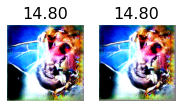

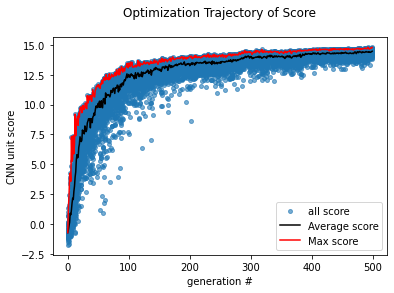

Last generation and Best code saved.


In [20]:
# run evolutions
t1 = time()
Exp.run(optim.get_init_pop())
t2 = time()
print(t2 - t1, "sec")  
Exp.visualize_best()
Exp.visualize_trajectory()
Exp.save_last_gen()

In [7]:
# print(Exp.__dict__)
batch_size = 256
model = Exp.get_model()
model

import torch
import torchvision
import torchvision.transforms as transforms

train_path = '/data/imagenet-2012/imagenet12/images/train'
transform = transforms.Compose(
    [transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)
imagenet_data = torchvision.datasets.ImageFolder(train_path, transform=transform)
data_loader = torch.utils.data.DataLoader(
    imagenet_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=12
)


In [8]:
scores = np.zeros((len(imagenet_data),2))

idx = 0
for img_batch, i in tqdm(data_loader, total=len(data_loader)): 
    CNNmodel = Exp.CNNmodel
    with torch.no_grad():
        CNNmodel.model(img_batch.to(CNNmodel.device))
    s = CNNmodel.activation["score"].squeeze().cpu().numpy().squeeze()
    
    scores[idx*batch_size:idx*batch_size+len(i),0] = s
    scores[idx*batch_size:idx*batch_size+len(i),1] = i
    idx += 1
    # if idx > 12:
    #      break
np.savez(f"imagenet_scores_{explabel}.npz",scores=scores[:,0], labels=scores[:,1])

100%|██████████| 4809/4809 [30:19<00:00,  2.64it/s]


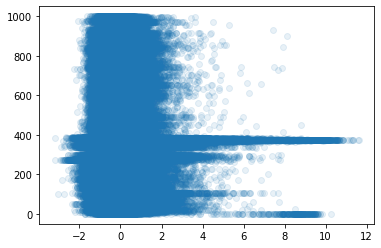

In [23]:
import matplotlib.pyplot as plt
# sc = scores[scores[:,0]>0,:]
plt.scatter(scores[:,0], scores[:,1], alpha=0.1)
# plt.hist(sc[:,0])

maxmedian = np.zeros((1000,2))

for i in range(1000):
    x = scores[scores[:,1]==i,0]
    maxmedian[i,0] = np.max(x)
    maxmedian[i,1] = np.median(x)
    


array([374, 374])

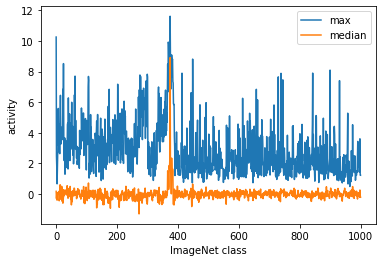

In [22]:

plt.plot(maxmedian, label=['max', 'median'])
plt.legend()
plt.gca().set_xlabel('ImageNet class')
plt.gca().set_ylabel('activity')

np.argmax(maxmedian,axis=0)

In [24]:
tmpsavedir = 'playground' # Temporary save directory

optim = CholeskyCMAES(4096, population_size=40, init_sigma=2.0, Aupdate_freq=10, init_code=np.zeros([1, 4096]))
explabel, model_unit = "vit_last373", ("vit_b_32", ".heads.Linearhead", 373, 373, 373)
Exp = ExperimentEvolution(model_unit, savedir=tmpsavedir, explabel=explabel, optimizer=optim, max_step=500, imgsize=(224, 224))

# run evolutions
t1 = time()
Exp.run(optim.get_init_pop())
t2 = time()
print(t2 - t1, "sec")  
Exp.visualize_best()
Exp.visualize_trajectory()
Exp.save_last_gen()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 20)

        120            Linear .encoder.layers.encoder_layer_11.mlp.Linear3
        121           Dropout .encoder.layers.encoder_layer_11.mlp.Dropout4
        122      EncoderBlock .encoder.layers.EncoderBlockencoder_layer_11
        123         LayerNorm .encoder.LayerNormln
        124           Encoder .Encoderencoder
        125            Linear .heads.Linearhead
        126      VisionTransformer .VisionTransformer